# Chest X-ray Classification and Localization using DenseNet

This notebook implements a transfer learning approach using DenseNet for chest X-ray classification and localization on the NIH Chest X-ray dataset.

In [1]:
!pip install torch torchvision pandas numpy matplotlib tqdm scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 22.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 39.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 252.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 215.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 204.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 24.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 66.7 M

In [149]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, RandomSampler
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from scipy.ndimage import zoom

In [3]:
def set_all_seeds(seed=10):
    import os, random, numpy as np, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
set_all_seeds(10)

## Data Loading and Preprocessing

In [5]:
IMAGES_PATH_RESIZED = os.path.join('resized_images_20k')
PREPROCESSED_IMAGES_PATH = os.path.join('bbox_resized_filtered_images_20k_labled.csv')
df_preprocessed = pd.read_csv(PREPROCESSED_IMAGES_PATH)

In [6]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ChestXrayDataset(Dataset):
    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Image Index']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # Get labels (binary classification: normal vs abnormal)
        label = 1 if self.df.iloc[idx]['Finding Label'] != 'No Finding' else 0
        return image, torch.tensor(label, dtype=torch.float32)

Using device: cuda


In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return > 0
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU

True
1
NVIDIA A40


In [8]:
def get_transforms():
    """Define image transformations."""
    return {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=(-10, 10)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

g = torch.Generator()
g.manual_seed(10)

# Split data and create data loaders
train_df, temp_df = train_test_split(df_preprocessed, test_size=0.3, random_state=10)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=10)

# Get transforms
transforms_dict = get_transforms()


In [9]:
# Create datasets
train_dataset = ChestXrayDataset(IMAGES_PATH_RESIZED, train_df, transform=transforms_dict['train'])
val_dataset = ChestXrayDataset(IMAGES_PATH_RESIZED, val_df, transform=transforms_dict['val'])
test_dataset = ChestXrayDataset(IMAGES_PATH_RESIZED, test_df, transform=transforms_dict['val'])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")



Training samples: 13839
Validation samples: 2966
Test samples: 2966


## Model Training

In [150]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attn_map = self.sigmoid(self.conv(x))  # Generate attention map
        return x * attn_map, attn_map

class ResNetWithAttention(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        # Load pre-trained ResNet18 instead of ResNet50
        resnet = models.resnet18(pretrained=True)
        
        # Remove the final fully connected layer
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        
        # Unfreeze more layers for fine-tuning
        for param in self.features.parameters():
            param.requires_grad = False
            
        # Unfreeze the last two blocks
        for param in list(self.features.children())[-3].parameters():
            param.requires_grad = True
        for param in list(self.features.children())[-2].parameters():
            param.requires_grad = True
        
        # Change from 2048 to 512 feature channels
        self.attention = SpatialAttention(512)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Change input dimension from 2048 to 512
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x, attn_map = self.attention(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits, attn_map

In [11]:
class AttentionMemory:
    def __init__(self, memory_size=5, alpha=0.7):
        """
        Args:
            memory_size: Number of previous epochs to consider
            alpha: Exponential moving average factor (higher = more weight to recent)
        """
        #Keep the last 5 attention maps per image
        self.memory_size = memory_size
        #Controls how much more we trust recent maps (lower = longer memory)
        self.alpha = alpha
        self.attention_history = {}  # Maps image_id -> list of attention maps
        self.correct_predictions = {}  # Maps image_id -> list of correctness flags
    
    def update(self, image_ids, attention_maps, predictions, labels):
        """Update memory with new attention maps"""
        for i, img_id in enumerate(image_ids):
            # Get current attention map and whether prediction was correct
            attn = attention_maps[i].detach().cpu()
            correct = (predictions[i].round() == labels[i]).all().float()
            
            # Initialize if first time seeing this image
            if img_id not in self.attention_history:
                self.attention_history[img_id] = []
                self.correct_predictions[img_id] = []
            
            # Add new data
            self.attention_history[img_id].append(attn)
            self.correct_predictions[img_id].append(correct.item())
            
            # Keep only most recent entries
            if len(self.attention_history[img_id]) > self.memory_size:
                self.attention_history[img_id].pop(0)
                self.correct_predictions[img_id].pop(0)
    
    def get_historical_attention(self, image_ids):
        """Get exponentially weighted historical attention maps"""
        batch_history = []
        
        for img_id in image_ids:
            if img_id not in self.attention_history or not self.attention_history[img_id]:
                # No history available
                batch_history.append(None)
                continue
            
            # Get history for this image
            history = self.attention_history[img_id]
            correctness = self.correct_predictions[img_id]
            
            if len(history) == 1:
                # Only one entry in history
                batch_history.append(history[0])
                continue
            
            # Calculate weighted average, giving more weight to:
            # 1. More recent attention maps
            # 2. Attention maps from correct predictions
            weights = []
            for i, is_correct in enumerate(correctness):
                # Position weight (more recent = higher weight)
                pos_weight = self.alpha ** (len(correctness) - i - 1)
                # Correctness weight (correct predictions get higher weight)
                correct_weight = 1.2 if is_correct else 0.8
                weights.append(pos_weight * correct_weight)
            
            # Normalize weights
            weights = [w / sum(weights) for w in weights]
            
            # Calculate weighted attention
            weighted_attn = torch.zeros_like(history[0])
            for i, attn in enumerate(history):
                weighted_attn += weights[i] * attn
            
            batch_history.append(weighted_attn)
        
        return batch_history

In [151]:
class SelfCorrectiveAttentionLoss(nn.Module):
    def __init__(self, lambda_consistency, lambda_sparsity):
        super(SelfCorrectiveAttentionLoss, self).__init__()
        self.cls_loss = nn.BCELoss()  # Keep BCE for multi-label
        self.lambda_consistency = lambda_consistency
        self.lambda_sparsity = lambda_sparsity
    
    def forward(self, pred, target, attn_map, historical_attn=None):
        # Classification loss (primary objective)
        cls_loss = self.cls_loss(pred, target)
        
        # Initialize attention losses
        consistency_loss = torch.tensor(0.0).to(pred.device)
        sparsity_loss = torch.tensor(0.0).to(pred.device)
        
        # Simpler sparsity loss
        attn_flat = attn_map.view(attn_map.size(0), -1)
        sparsity_loss = -torch.mean(torch.sum(attn_flat * torch.log(attn_flat + 1e-8), dim=1)) / 1000
        
        # Consistency loss (if historical attention is available)
        if historical_attn is not None:
            valid_indices = [i for i, h in enumerate(historical_attn) if h is not None]
            
            if valid_indices:
                valid_hist = torch.stack([historical_attn[i] for i in valid_indices]).to(pred.device)
                valid_curr = attn_map[valid_indices]
                
                # For multi-label, consider prediction correct if all labels match
                correct_mask = (pred.round() == target).all(dim=1).float()[valid_indices].view(-1, 1, 1)
                incorrect_mask = 1 - correct_mask
                
                consistency_term = torch.abs(valid_curr - valid_hist) * correct_mask
                correction_term = torch.exp(-torch.abs(valid_curr - valid_hist)) * incorrect_mask
                
                consistency_loss = torch.mean(consistency_term + correction_term)
        
        # Total loss with reduced weights
        total_loss = cls_loss + self.lambda_consistency * consistency_loss + self.lambda_sparsity * sparsity_loss
        
        return total_loss, cls_loss, consistency_loss, sparsity_loss

In [13]:
def visualize_attention_maps(model, data_loader, num_samples=5, save_dir='attention_maps'):
    """
    Visualize attention maps for a few samples
    
    Args:
        model: Trained model
        data_loader: DataLoader for the dataset
        num_samples: Number of samples to visualize
        save_dir: Directory to save visualizations
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    
    # Get a few samples
    samples = []
    for images, labels, img_ids in data_loader:
        for i in range(min(len(images), num_samples - len(samples))):
            samples.append((images[i], labels[i], img_ids[i]))
        if len(samples) >= num_samples:
            break
    
    with torch.no_grad():
        for i, (image, label, img_id) in enumerate(samples):
            # Get model prediction and attention map
            image = image.unsqueeze(0).to(device)
            logit, attn_map = model(image)
            pred = torch.sigmoid(logit).item()
            
            # Convert to numpy for visualization
            image_np = image.squeeze().cpu().numpy().transpose(1, 2, 0)
            # Denormalize image
            image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)
            
            # Get attention map
            attn_map_np = attn_map.squeeze().cpu().numpy()
            
            # Create visualization
            plt.figure(figsize=(12, 5))
            
            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(image_np)
            plt.title(f"Original Image\nTrue: {label.item()}")
            plt.axis('off')
            
            # Attention map
            plt.subplot(1, 3, 2)
            plt.imshow(attn_map_np, cmap='coolwarm')
            plt.title(f"Attention Map\nPred: {pred:.4f}")
            plt.axis('off')
            
            # Overlay
            plt.subplot(1, 3, 3)
            plt.imshow(image_np)
            plt.imshow(attn_map_np, cmap='coolwarm', alpha=0.5)
            plt.title("Overlay")
            plt.axis('off')
            
            plt.tight_layout()
            plt.savefig(f"{save_dir}/attention_{img_id.replace('.', '_')}.png")
            plt.close()

In [144]:
def visualize_tracked_image_history(history_data, data_loader, save_dir='attention_history'):
    """
    Visualize the attention maps for a tracked image across all epochs.
    
    Args:
        history_data: Dictionary containing tracked attention history
        data_loader: DataLoader to get the original image
        save_dir: Directory to save visualizations
    """
    os.makedirs(save_dir, exist_ok=True)
    image_id = history_data['image_id']
    attention_maps = history_data['attention_maps']
    epochs = history_data['epochs']
    predictions = history_data['predictions']
    correctness = history_data['correct']
    
    # Get original image
    original_image = None
    original_label = None
    for images, labels, img_ids in data_loader:
        if image_id in img_ids:
            idx = img_ids.index(image_id)
            original_image = images[idx].cpu().numpy().transpose(1, 2, 0)
            # Denormalize image
            original_image = original_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            original_image = np.clip(original_image, 0, 1)
            original_label = labels[idx].cpu().numpy()
            break
    
    if original_image is None:
        print(f"Image {image_id} not found in data loader")
        return
    
    # Create grid visualization
    num_epochs = len(epochs)
    rows = max(2, int(np.ceil(np.sqrt(num_epochs + 1))))
    cols = int(np.ceil((num_epochs + 1) / rows))
    
    plt.figure(figsize=(cols * 4, rows * 3))
    
    # Plot original image
    plt.subplot(rows, cols, 1)
    if original_image.ndim == 2:
        plt.imshow(original_image, cmap='gray')
    else:
        plt.imshow(original_image)
    plt.title(f"Original Image\nID: {image_id}")
    plt.axis('off')
    
    # Plot attention maps by epoch
    for i, (attn, epoch, pred, correct) in enumerate(zip(attention_maps, epochs, predictions, correctness)):
        attn_np = attn.squeeze().numpy()
        
        # Plot attention map
        plt.subplot(rows, cols, i + 2)
        plt.imshow(attn_np, cmap='plasma')
        plt.title(f"Epoch {epoch}\nCorrect: {correct}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{image_id.replace('.', '_')}_attention_history.png")
    plt.close()
    
    # Create overlay visualization
    plt.figure(figsize=(cols * 4, rows * 3))
    
    # Plot original image
    plt.subplot(rows, cols, 1)
    if original_image.ndim == 2:
        plt.imshow(original_image, cmap='gray')
    else:
        plt.imshow(original_image)
    plt.title(f"Original Image\nID: {image_id}")
    plt.axis('off')

    
    # Plot overlays by epoch
    for i, (attn, epoch, pred, correct) in enumerate(zip(attention_maps, epochs, predictions, correctness)):
        attn_np = attn.squeeze().numpy()

        attn_resized = zoom(attn_np, (original_image.shape[0] / attn_np.shape[0],
                                      original_image.shape[1] / attn_np.shape[1]))

        # Plot overlay
        plt.subplot(rows, cols, i + 2)
        im = plt.imshow(attn_resized, cmap='plasma')
        if original_image.ndim == 2:
            plt.imshow(original_image, cmap='gray', alpha=0.35)
        else:
            plt.imshow(original_image, alpha=0.35)
        
        plt.title(f"Epoch {epoch}\nCorrect: {correct}")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{image_id.replace('.', '_')}_attention_overlays.png")
    plt.close()
    
    print(f"Visualized attention history for image {image_id} across {num_epochs} epochs")

In [152]:
def train_with_self_correction(model, train_loader, val_loader, num_epochs=15, track_image_id=None):
    """
    Train the model with self-corrective attention 
    """
    """
    Train the model with self-corrective attention 
    """
    # Initialize attention memory
    memory = AttentionMemory(memory_size=3, alpha=0.7)

    # For tracking a specific image's attention maps across all epochs
    tracked_attention_history = {
        'image_id': track_image_id,
        'epochs': [],
        'attention_maps': [],
        'predictions': [],
        'correct': []
    }

    # Loss and optimizer
    criterion = SelfCorrectiveAttentionLoss(lambda_consistency=0.07, lambda_sparsity=0.1)

    optimizer = optim.AdamW([
        {'params': list(model.features.children())[-2].parameters(), 'lr': 1e-5},
        {'params': model.attention.parameters(), 'lr': 2e-5},
        {'params': model.classifier.parameters(), 'lr': 2e-5}
    ], weight_decay=1e-4) 

    # Learning rate scheduler with more patience
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.7, patience=5, verbose=True
    )
        
    # Track metrics
    best_val_loss = float('inf')
    history = {
        'train_loss': [], 'train_acc': [], 'train_auc': [],
        'val_loss': [], 'val_acc': [], 'val_auc': [],
        'cls_loss': [], 'consistency_loss': [], 'sparsity_loss': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        epoch_cls_loss = 0.0
        epoch_consistency_loss = 0.0
        epoch_sparsity_loss = 0.0
        
        # For AUC calculation
        train_preds = []
        train_labels = []
        
        for images, labels, img_ids in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            labels = labels.to(device)
            
            # Get historical attention maps for batch
            historical_attn = memory.get_historical_attention(img_ids)
            
            # Forward pass
            optimizer.zero_grad()
            logits, attn_maps = model(images)     
            
            # Calculate loss
            loss, cls_loss, consistency_loss, sparsity_loss = criterion(
                logits, labels, attn_maps, historical_attn
            )
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track metrics
            train_loss += loss.item()
            epoch_cls_loss += cls_loss.item()
            epoch_consistency_loss += consistency_loss.item()
            epoch_sparsity_loss += sparsity_loss.item()
            
            # Calculate accuracy (all labels must match)
            preds = (logits > 0.5).float()
            train_correct += (preds == labels).all(dim=1).sum().item()

            # Store predictions and labels for AUC
            train_preds.append(logits.detach().cpu().numpy())
            train_labels.append(labels.cpu().numpy())
            
            if track_image_id is not None and track_image_id in img_ids:
                idx = img_ids.index(track_image_id)
                tracked_attention_history['epochs'].append(epoch + 1)
                tracked_attention_history['attention_maps'].append(attn_maps[idx].detach().cpu())
                tracked_attention_history['predictions'].append(logits[idx].detach().cpu())
                tracked_attention_history['correct'].append((logits[idx].round() == labels[idx]).all().item())

            
            # Update attention memory
            memory.update(img_ids, attn_maps, logits, labels)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0

        # For AUC calculation
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for images, labels, img_ids in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                # Get historical attention
                historical_attn = memory.get_historical_attention(img_ids)
                
                # Forward pass
                logits, attn_maps = model(images)
                
                # Calculate loss
                loss, _, _, _ = criterion(logits, labels, attn_maps, historical_attn)
                
                # Track metrics
                val_loss += loss.item()
                preds = (logits > 0.5).float()
                val_correct += (preds == labels).all(dim=1).sum().item()

                # Store predictions and labels for AUC
                val_preds.append(logits.cpu().numpy())
                val_labels.append(labels.cpu().numpy())
        
        # Calculate epoch metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_cls_loss = epoch_cls_loss / len(train_loader)
        avg_consistency_loss = epoch_consistency_loss / len(train_loader)
        avg_sparsity_loss = epoch_sparsity_loss / len(train_loader)
        train_accuracy = 100 * train_correct / len(train_loader.dataset)

        # Convert lists to numpy arrays for AUC calculation
        train_preds = np.concatenate(train_preds, axis=0)
        train_labels = np.concatenate(train_labels, axis=0)
        val_preds = np.concatenate(val_preds, axis=0)
        val_labels = np.concatenate(val_labels, axis=0)
        
        # Calculate per-label AUC and average
        train_aucs = [roc_auc_score(train_labels[:, i], train_preds[:, i]) 
                     for i in range(train_preds.shape[1])]
        train_auc = np.mean(train_aucs)
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / len(val_loader.dataset)
        
        # Calculate per-label AUC and average for validation
        val_aucs = [roc_auc_score(val_labels[:, i], val_preds[:, i]) 
                   for i in range(val_preds.shape[1])]
        val_auc = np.mean(val_aucs)
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['train_auc'].append(train_auc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['val_auc'].append(val_auc)
        history['cls_loss'].append(avg_cls_loss)
        history['consistency_loss'].append(avg_consistency_loss)
        history['sparsity_loss'].append(avg_sparsity_loss)
        
        # Print metrics
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f} (Cls: {avg_cls_loss:.4f}, ' + 
              f'Consistency: {avg_consistency_loss:.4f}, Sparsity: {avg_sparsity_loss:.4f})')
        print(f'Train Accuracy: {train_accuracy:.2f}%, AUC: {train_auc:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, AUC: {val_auc:.4f}')
        
        # Update scheduler
        scheduler.step(val_auc)  # Use AUC for scheduling
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model_self_corrective.pth')
            print('Model saved!')
        
        print('-' * 60)
    
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Loss curves
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.legend()
    
    # Plot 2: Accuracy curves
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    plt.legend()
    
    # Plot 3: AUC curves
    plt.subplot(2, 2, 3)
    plt.plot(history['train_auc'], label='Train AUC')
    plt.plot(history['val_auc'], label='Validation AUC')
    plt.title('AUC Curves')
    plt.xlabel('Epoch')
    plt.ylabel('AUC Score')
    plt.ylim(0, 1)
    plt.legend()
    
    # Plot 4: Component losses
    plt.subplot(2, 2, 4)
    plt.plot(history['cls_loss'], label='Classification Loss')
    plt.plot(history['consistency_loss'], label='Consistency Loss')
    plt.plot(history['sparsity_loss'], label='Sparsity Loss')
    plt.title('Component Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.close()
    
    return model, history, tracked_attention_history

In [61]:
class ChestXrayDatasetWithIDs(Dataset):
    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        
        # Create label encoder for the Finding Label column
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(df['Finding Label'])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Image Index']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # Get label and convert to one-hot encoding
        label = self.df.iloc[idx]['Finding Label']
        label_idx = self.label_encoder.transform([label])[0]
        num_classes = len(self.label_encoder.classes_)
        label_onehot = torch.zeros(num_classes, dtype=torch.float32)
        label_onehot[label_idx] = 1.0
        
        # Return image ID along with image and labels
        return image, label_onehot, img_name

# Create datasets with image IDs
train_dataset = ChestXrayDatasetWithIDs(IMAGES_PATH_RESIZED, train_df, transform=transforms_dict['train'])
val_dataset = ChestXrayDatasetWithIDs(IMAGES_PATH_RESIZED, val_df, transform=transforms_dict['val'])
test_dataset = ChestXrayDatasetWithIDs(IMAGES_PATH_RESIZED, test_df, transform=transforms_dict['val'])

batch_size = 32
# Create data loaders
g = torch.Generator()
g.manual_seed(10)

sampler = RandomSampler(train_dataset, replacement=False)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, generator=g, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.label_encoder.classes_)}")
print("Classes:", train_dataset.label_encoder.classes_)

Training samples: 13839
Validation samples: 2966
Test samples: 2966
Number of classes: 10
Classes: ['Atelectasis' 'Cardiomegaly' 'Effusion' 'Infiltrate' 'Infiltration'
 'Mass' 'No Finding' 'Nodule' 'Pneumonia' 'Pneumothorax']


In [ ]:
for images, labels, img_ids in train_loader:
    print(f"Sample image IDs: {img_ids[:5]}")
    
    # Check if any IDs are None or empty strings
    if any(id is None or id == '' for id in img_ids):
        print("WARNING: Found missing image IDs!")
        
    # Check if IDs are unique in this batch
    if len(set(img_ids)) != len(img_ids):
        print("WARNING: Non-unique image IDs in batch!")
        
    break  # Just check one batch

_,_,img_ids = train_loader.dataset[0]
print(img_ids)

Sample image IDs: ['00002644_011.png', '00006271_024.png', '00001684_031.png', '00001434_000.png', '00008180_006.png']
00004750_006.png


In [153]:
# Create model
num_classes = len(train_dataset.label_encoder.classes_)
model = ResNetWithAttention(num_classes=num_classes).to(device)

sample_img_id = None
for _, _, img_ids in train_loader:
    sample_img_id = img_ids[0]  # Use first image from validation set
    break

# Train with self-correction
trained_model, history, tracked_attention_history = train_with_self_correction(model, train_loader, val_loader, num_epochs=10, track_image_id=sample_img_id)

/root/XAI_medical_deeplearning/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/XAI_medical_deeplearning/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/XAI_medical_deeplearning/myenv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10: 100%|██████████| 433/433 [00:12<00:00, 35.64it/s]


Epoch 1/10:
Train Loss: 0.4983 (Cls: 0.4971, Consistency: 0.0000, Sparsity: 0.0126)
Train Accuracy: 15.29%, AUC: 0.5242
Validation Loss: 0.3210, Accuracy: 24.95%, AUC: 0.5384
Model saved!
------------------------------------------------------------


Epoch 2/10: 100%|██████████| 433/433 [00:14<00:00, 29.95it/s]


Epoch 2/10:
Train Loss: 0.3432 (Cls: 0.2988, Consistency: 0.6243, Sparsity: 0.0070)
Train Accuracy: 32.19%, AUC: 0.5414
Validation Loss: 0.2457, Accuracy: 28.25%, AUC: 0.5752
Model saved!
------------------------------------------------------------


Epoch 3/10: 100%|██████████| 433/433 [00:14<00:00, 30.30it/s]


Epoch 3/10:
Train Loss: 0.2873 (Cls: 0.2438, Consistency: 0.6171, Sparsity: 0.0033)
Train Accuracy: 34.01%, AUC: 0.5786
Validation Loss: 0.2196, Accuracy: 32.27%, AUC: 0.6003
Model saved!
------------------------------------------------------------


Epoch 4/10: 100%|██████████| 433/433 [00:14<00:00, 30.31it/s]


Epoch 4/10:
Train Loss: 0.2658 (Cls: 0.2220, Consistency: 0.6229, Sparsity: 0.0019)
Train Accuracy: 34.52%, AUC: 0.6014
Validation Loss: 0.2074, Accuracy: 33.61%, AUC: 0.6171
Model saved!
------------------------------------------------------------


Epoch 5/10: 100%|██████████| 433/433 [00:14<00:00, 29.05it/s]


Epoch 5/10:
Train Loss: 0.2547 (Cls: 0.2107, Consistency: 0.6280, Sparsity: 0.0013)
Train Accuracy: 35.72%, AUC: 0.6122
Validation Loss: 0.2016, Accuracy: 35.50%, AUC: 0.6388
Model saved!
------------------------------------------------------------


Epoch 6/10: 100%|██████████| 433/433 [00:14<00:00, 29.54it/s]


Epoch 6/10:
Train Loss: 0.2477 (Cls: 0.2041, Consistency: 0.6211, Sparsity: 0.0011)
Train Accuracy: 37.16%, AUC: 0.6295
Validation Loss: 0.1972, Accuracy: 35.50%, AUC: 0.6463
Model saved!
------------------------------------------------------------


Epoch 7/10: 100%|██████████| 433/433 [00:14<00:00, 29.66it/s]


Epoch 7/10:
Train Loss: 0.2427 (Cls: 0.1994, Consistency: 0.6175, Sparsity: 0.0010)
Train Accuracy: 37.75%, AUC: 0.6437
Validation Loss: 0.1939, Accuracy: 36.48%, AUC: 0.6602
Model saved!
------------------------------------------------------------


Epoch 8/10: 100%|██████████| 433/433 [00:14<00:00, 29.63it/s]


Epoch 8/10:
Train Loss: 0.2386 (Cls: 0.1960, Consistency: 0.6072, Sparsity: 0.0010)
Train Accuracy: 38.88%, AUC: 0.6551
Validation Loss: 0.1920, Accuracy: 38.47%, AUC: 0.6828
Model saved!
------------------------------------------------------------


Epoch 9/10: 100%|██████████| 433/433 [00:14<00:00, 29.95it/s]


Epoch 9/10:
Train Loss: 0.2359 (Cls: 0.1939, Consistency: 0.5983, Sparsity: 0.0010)
Train Accuracy: 39.80%, AUC: 0.6696
Validation Loss: 0.1905, Accuracy: 40.02%, AUC: 0.7000
Model saved!
------------------------------------------------------------


Epoch 10/10: 100%|██████████| 433/433 [00:16<00:00, 26.72it/s]


Epoch 10/10:
Train Loss: 0.2333 (Cls: 0.1918, Consistency: 0.5923, Sparsity: 0.0010)
Train Accuracy: 40.47%, AUC: 0.6807
Validation Loss: 0.1887, Accuracy: 40.53%, AUC: 0.7079
Model saved!
------------------------------------------------------------


In [12]:
memory = AttentionMemory(memory_size=5, alpha=0.7)

In [147]:
print(tracked_attention_history)

{'image_id': '00000991_000.png', 'epochs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'attention_maps': [tensor([[[0.6377, 0.7102, 0.6693, 0.7289, 0.7372, 0.7324, 0.5919],
         [0.7702, 0.8264, 0.6358, 0.7233, 0.8536, 0.8468, 0.5775],
         [0.7562, 0.8220, 0.5346, 0.5045, 0.6446, 0.5516, 0.4201],
         [0.6708, 0.7422, 0.5542, 0.4657, 0.3290, 0.2793, 0.2839],
         [0.4936, 0.6422, 0.6567, 0.6146, 0.4061, 0.3556, 0.3603],
         [0.5456, 0.5198, 0.5274, 0.5762, 0.6077, 0.6037, 0.4470],
         [0.4575, 0.3669, 0.4385, 0.5129, 0.5930, 0.5461, 0.4984]]]), tensor([[[0.7935, 0.8678, 0.7715, 0.8476, 0.8344, 0.8760, 0.7586],
         [0.8998, 0.9407, 0.9173, 0.8356, 0.8564, 0.8512, 0.7737],
         [0.8274, 0.9104, 0.9088, 0.8359, 0.7608, 0.6818, 0.5832],
         [0.7824, 0.8844, 0.9195, 0.8377, 0.6570, 0.4181, 0.4058],
         [0.5316, 0.5669, 0.7062, 0.6702, 0.5562, 0.3493, 0.4080],
         [0.3595, 0.3067, 0.3362, 0.2693, 0.2003, 0.3082, 0.4635],
         [0.3672, 0.2609, 0.320

In [154]:
if sample_img_id is not None and tracked_attention_history['attention_maps']:
    visualize_tracked_image_history(tracked_attention_history, train_loader)

Visualized attention history for image 00003160_001.png across 10 epochs


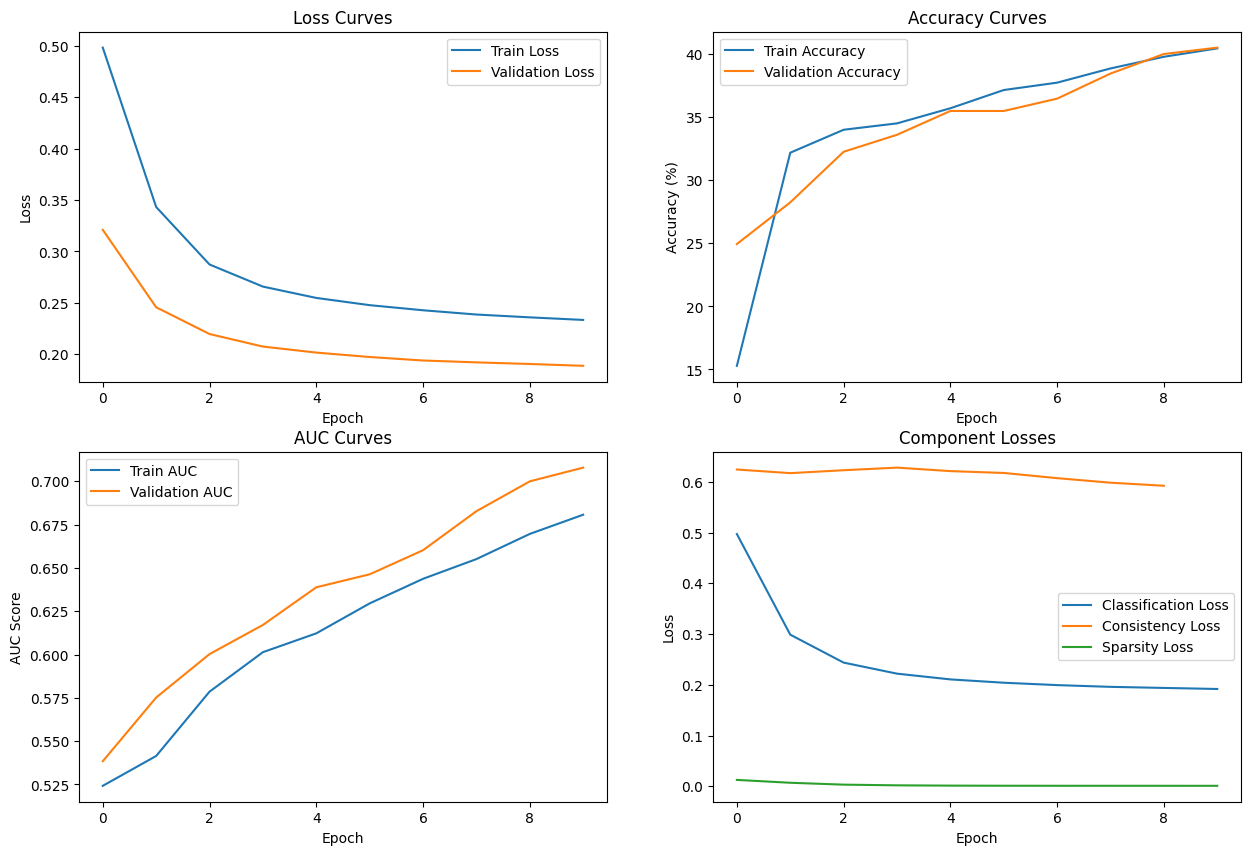

In [155]:
plt.figure(figsize=(15, 10))
    
# Plot 1: Loss curves
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot 2: Accuracy curves
plt.subplot(2, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot 3: AUC curves
plt.subplot(2, 2, 3)
plt.plot(history['train_auc'], label='Train AUC')
plt.plot(history['val_auc'], label='Validation AUC')
plt.title('AUC Curves')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')

plt.legend()

# Plot 4: Component losses
plt.subplot(2, 2, 4)
plt.plot(history['cls_loss'], label='Classification Loss')
plt.plot(history['consistency_loss'][1:], label='Consistency Loss')
plt.plot(history['sparsity_loss'], label='Sparsity Loss')
plt.title('Component Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.tight_layout()
plt.savefig('training_metrics_detail.png')
plt.close()

